<a href="https://colab.research.google.com/github/robinjameslee/Deribit-Cash-and-Carry-Trade/blob/main/Deribit_Cash_and_Carry_Trade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script aims to have a look at the Cash and Carry Trade Yield regarding  futures listed on Deribit.

Data are queried using Deribit's API: [docs.deribit.com](https://docs.deribit.com)

In [ ]:
import json
import requests
import pandas as pd

pd.set_option('display.float_format', '{:.10f}'.format)

def get_instruments(currency, kind, expired='false'):
  url = 'https://www.deribit.com/api/v2/public/get_instruments?'
  parameters = {'currency': currency, 'kind': kind, 'expired': expired}
  res = requests.get(url, params=parameters)
  res_dict = json.loads(res.content)['result']
  return res_dict

def get_instruments_history(instrument_name, start_timestamp, end_timestamp, resolution='1D'):
  url = 'https://www.deribit.com/api/v2/public/get_tradingview_chart_data'
  parameters = {'instrument_name': instrument_name, 'start_timestamp': start_timestamp, 'end_timestamp': end_timestamp, 'resolution': resolution}
  res = requests.get(url, params=parameters)
  res_dict = json.loads(res.content)['result']
  return res_dict

target_underlying = 'ETH' #BTC or ETH
underlying_futures = get_instruments(target_underlying, 'future')
futures_name_list = [future['instrument_name'] for future in underlying_futures if future['settlement_period'] != 'perpetual']
futures_expiry_list = {future['instrument_name']: pd.to_datetime(future['expiration_timestamp'], unit='ms')  for future in underlying_futures if future['settlement_period'] != 'perpetual'}

In [ ]:
#Get available historical closing price for all futures with expiration dates
futures_df = pd.DataFrame()

for future in underlying_futures:
  if future['settlement_period'] != 'perpetual':
    instrument_name = future['instrument_name']
    res = get_instruments_history(instrument_name,
                                  start_timestamp=future['creation_timestamp'],
                                  end_timestamp=future['expiration_timestamp'],
                                  resolution = '1D')
    df = pd.DataFrame(res)[['ticks', 'close']]
    df = df.rename(columns={'ticks': 'time', 'close': instrument_name})

    if len(futures_df) == 0:
      futures_df = df
    else:
      futures_df = futures_df.merge(df, on='time', how='outer', sort=True).reset_index(drop=True)

In [ ]:
#Get spot historical data and merge with futures dataframe
res = get_instruments_history(f'{target_underlying}_USDC',
                              start_timestamp=futures_df['time'].min(),
                              end_timestamp=futures_df['time'].max(),
                              resolution = '1D')
spot_df = pd.DataFrame(res)[['ticks', 'close']]
spot_df = spot_df.rename(columns={'ticks': 'time', 'close': target_underlying})
spot_df = futures_df.merge(spot_df, on='time', how='outer', sort=True).reset_index(drop=True)
spot_df['time'] = pd.to_datetime(spot_df['time'], unit='ms')
spot_df = spot_df.set_index('time')

In [ ]:
#Calculate annualized premium % per contract
futures_premiums = spot_df.copy() #an extra df for observing the premiums in points
futures_premiums_ann_pct = spot_df.copy()

def pct_diff(col_1, col_2):
  return (col_1 / col_2) - 1

for column in futures_premiums.iloc[:,:-1]:
  futures_premiums[column] = pct_diff(futures_premiums[column], futures_premiums[target_underlying])
  futures_premiums_ann_pct[column] = (1 + futures_premiums[column]) ** (365 / (futures_expiry_list[column] - futures_premiums.index).days) - 1 #Annauzlied yield, (1 + premium %) ** (365 / day to expiration) - 1

futures_premiums_ann_pct

,ETH-26JUL24,ETH-2AUG24,ETH-30AUG24,ETH-27SEP24,ETH-27DEC24,ETH-28MAR25,ETH-27JUN25,ETH
time,,,,,,,,
2023-09-29 08:00:00,NaN,NaN,NaN,0.0389844545,NaN,NaN,NaN,1672.0000000000
2023-09-30 08:00:00,NaN,NaN,NaN,0.0321731292,NaN,NaN,NaN,1680.0000000000
2023-10-01 08:00:00,NaN,NaN,NaN,0.0346115080,NaN,NaN,NaN,1728.9100000000
2023-10-02 08:00:00,NaN,NaN,NaN,0.0391610824,NaN,NaN,NaN,1663.5800000000
2023-10-03 08:00:00,NaN,NaN,NaN,0.0418264398,NaN,NaN,NaN,1642.7500000000
...,...,...,...,...,...,...,...,...
2024-07-17 08:00:00,0.1028357728,NaN,0.1121652892,0.1158061839,0.1127221965,0.1087393770,0.1088296810,3434.7000000000
2024-07-18 08:00:00,0.0941707722,NaN,0.1140484118,0.1118328130,0.1126967636,0.1079777360,0.1044123546,3393.3000000000
2024-07-19 08:00:00,0.0961327981,0.1216156792,0.1445446578,0.1326695603,0.1184258405,0.1124075053,0.1071561246,3490.6000000000


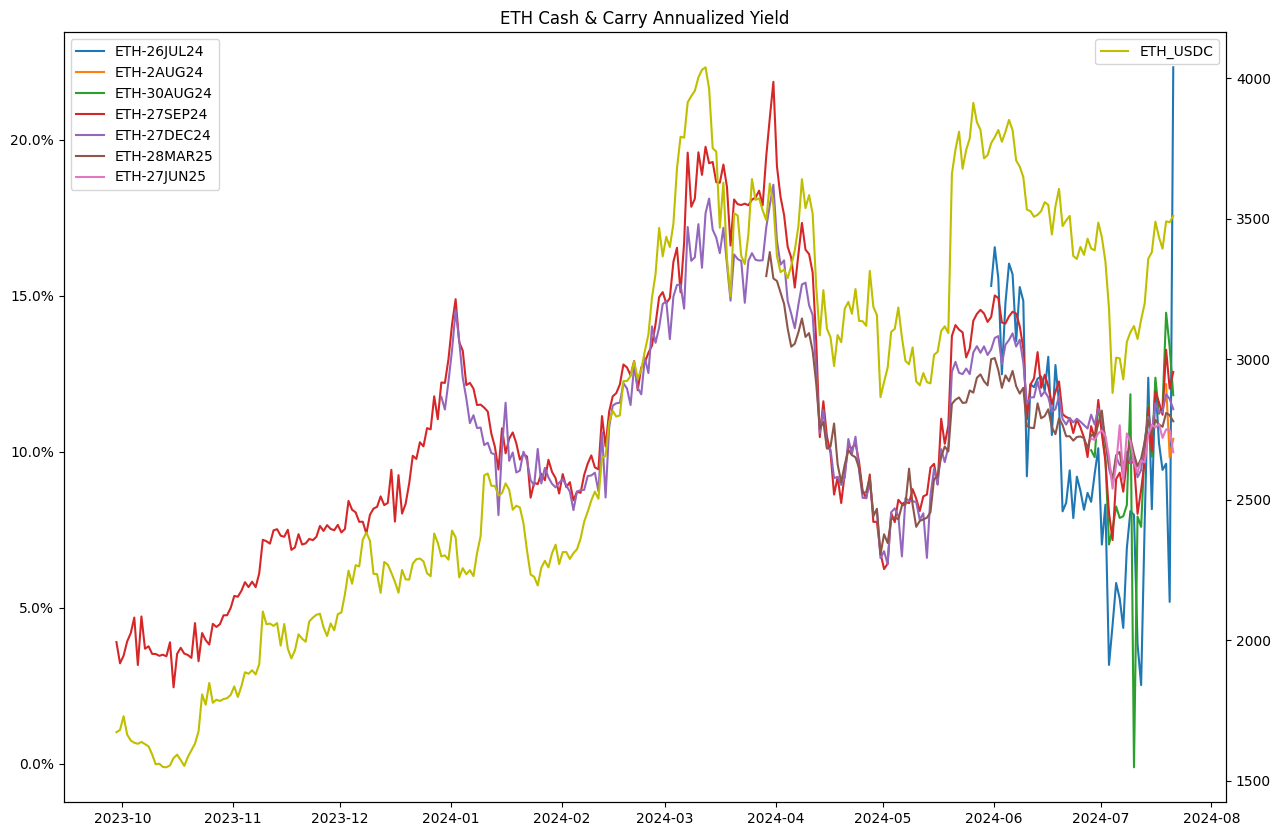

In [ ]:
#Plot the annualized yield for all futures
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

fig, ax1 = plt.subplots(1,1,figsize=(15,10))
ax2 = ax1.twinx()

for futures in futures_name_list:
  ax1.plot(futures_premiums_ann_pct.index, futures_premiums_ann_pct[futures], label=futures)

ax2.plot(futures_premiums_ann_pct.index, futures_premiums_ann_pct[target_underlying], label=f'{target_underlying}_USDC', color='y')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xlabel('Time')
plt.xlabel('Annualized yield')
plt.title(f'{target_underlying} Cash & Carry Annualized Yield')
ax1.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

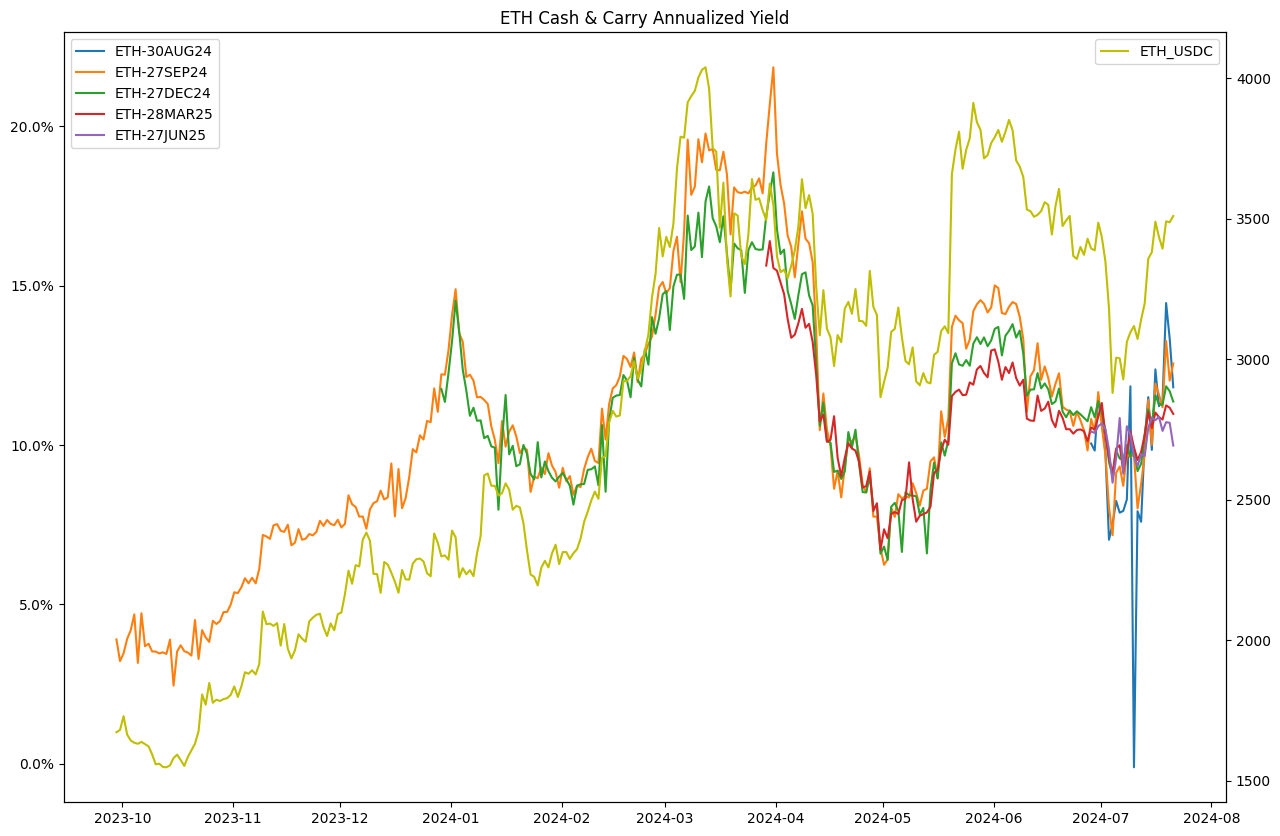

In [ ]:
#Filter out futures with expiry date < 30 days
import datetime
futures_filtered_expiry_list = {key: values for (key, values) in futures_expiry_list.items() if values >= datetime.datetime.today() + datetime.timedelta(days=30)}
futures_filtered_name_list = futures_filtered_expiry_list.keys()

#Plot the annualized yield for all filtered futures
fig, ax1 = plt.subplots(1,1,figsize=(15,10))
ax2 = ax1.twinx()

for futures in futures_filtered_name_list:
  ax1.plot(futures_premiums_ann_pct.index, futures_premiums_ann_pct[futures], label=futures)

ax2.plot(futures_premiums_ann_pct.index, futures_premiums_ann_pct[target_underlying], label=f'{target_underlying}_USDC', color='y')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xlabel('Time')
plt.xlabel('Annualized yield')
plt.title(f'{target_underlying} Cash & Carry Annualized Yield')
ax1.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()